# COVID-19 Literature Clustering

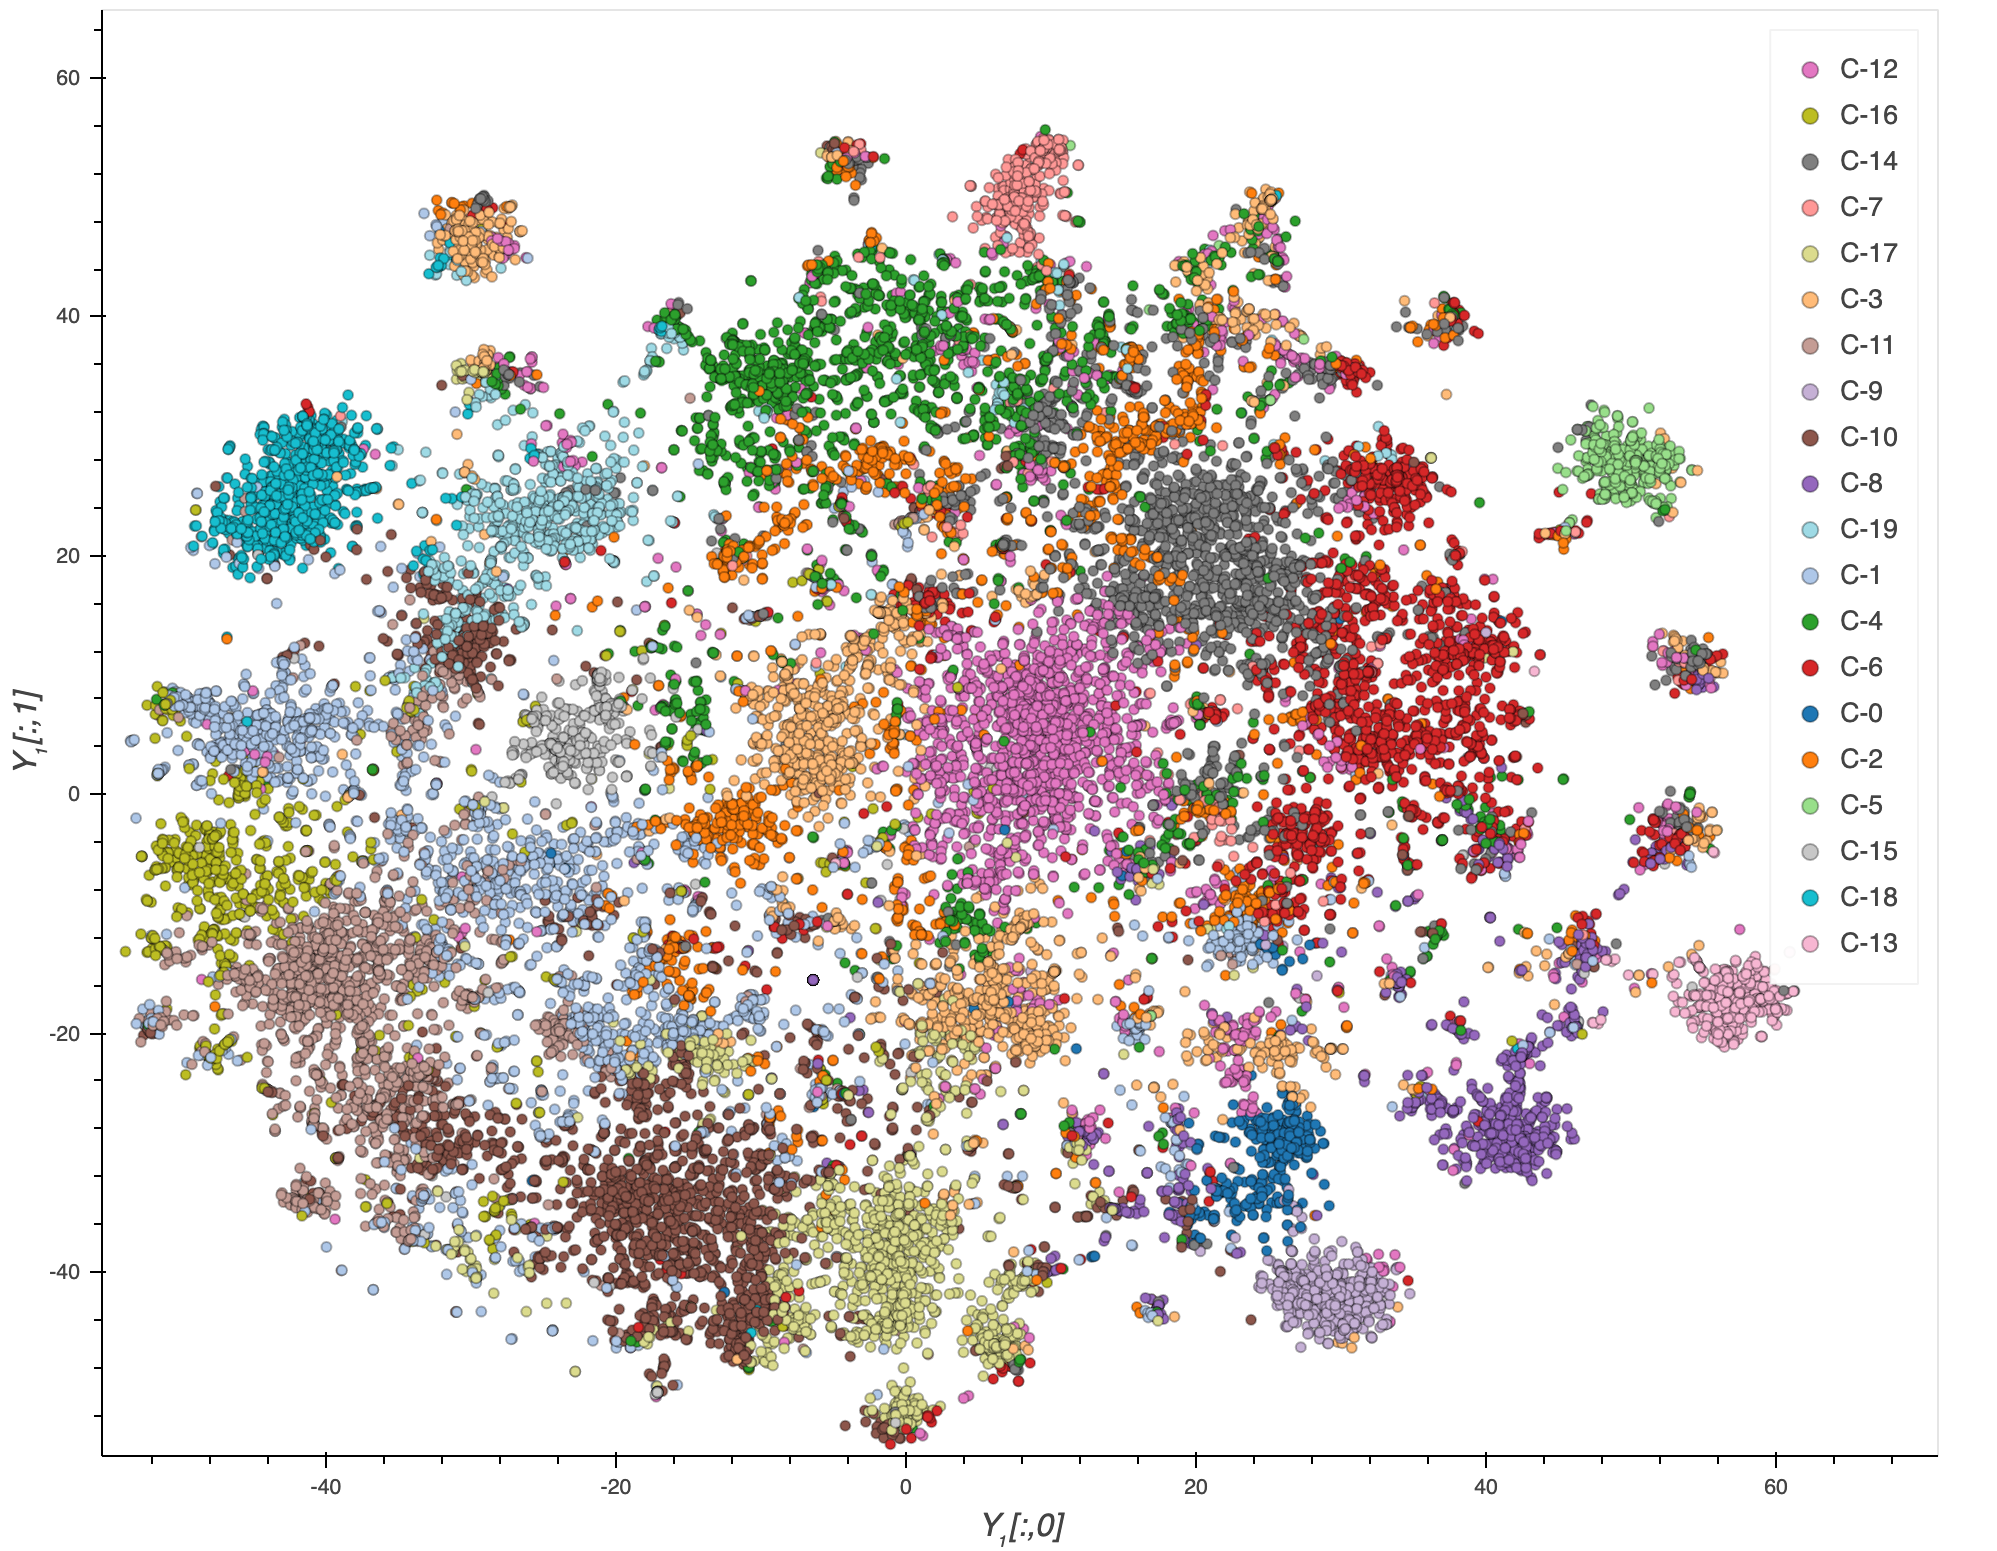

In [1]:
from IPython.display import Image
Image(filename='cover/bokeh_plot.png', width=800, height=800)

In [2]:
import numpy as np
import pandas as pd
import glob
import json

import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [3]:
root_path = 'COVID19-Literature-Clustering-master/cord_19_embeddings_2020-12-17.csv'
metadata_path = f'metadata.csv'
meta_df = pd.read_csv(metadata_path, dtype={
    'pubmed_id': str,
    'Microsoft Academic Paper ID': str, 
    'doi': str
})
meta_df.head()

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (1,5,13,14,15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


cord_uid                                       sha source_x  \
0  ug7v899j  d1aafb70c066a2068b02786f8929fd9c900897fb      PMC   
1  02tnwd4m  6b0567729c2143a66d737eb0a2f63f2dce2e5a7d      PMC   
2  ejv2xln0  06ced00a5fc04215949aa72528f2eeaae1d58927      PMC   
3  2b73a28n  348055649b6b8cf2b9a376498df9bf41f7123605      PMC   
4  9785vg6d  5f48792a5fa08bed9f56016f4981ae2ca6031b32      PMC   

                                               title                    doi  \
0  Clinical features of culture-proven Mycoplasma...  10.1186/1471-2334-1-6   
1  Nitric oxide: a pro-inflammatory mediator in l...           10.1186/rr14   
2    Surfactant protein-D and pulmonary host defense           10.1186/rr19   
3               Role of endothelin-1 in lung disease           10.1186/rr44   
4  Gene expression in epithelial cells in respons...           10.1186/rr61   

      pmcid pubmed_id license  \
0  PMC35282  11472636   no-cc   
1  PMC59543  11667967   no-cc   
2  PMC59549  11667972   no-cc   
3  PMC59574  11686871   no-cc   
4  PMC59580  11686888   no-cc   

                                            abstract publish_time  \
0  OBJECTIVE: This retrospective chart review des...   2001-07-04   
1  Inflammatory diseases of the respiratory tract...   2000-08-15   
2  Surfactant protein-D (SP-D) participates in th...   2000-08-25   
3  Endothelin-1 (ET-1) is a 21 amino acid peptide...   2001-02-22   
4  Respiratory syncytial virus (RSV) and pneumoni...   2001-05-11   

                                             authors         journal  mag_id  \
0                Madani, Tariq A; Al-Ghamdi, Aisha A  BMC Infect Dis     NaN   
1  Vliet, Albert van der; Eiserich, Jason P; Cros...      Respir Res     NaN   
2                                    Crouch, Erika C      Respir Res     NaN   
3  Fagan, Karen A; McMurtry, Ivan F; Rodman, David M      Respir Res     NaN   
4  Domachowske, Joseph B; Bonville, Cynthia A; Ro...      Respir Res     NaN   

  who_covidence_id arxiv_id  \
0              NaN      NaN   
1              NaN      NaN   
2              NaN      NaN   
3              NaN      NaN   
4              NaN      NaN   

                                      pdf_json_files  \
0  document_parses/pdf_json/d1aafb70c066a2068b027...   
1  document_parses/pdf_json/6b0567729c2143a66d737...   
2  document_parses/pdf_json/06ced00a5fc04215949aa...   
3  document_parses/pdf_json/348055649b6b8cf2b9a37...   
4  document_parses/pdf_json/5f48792a5fa08bed9f560...   

                               pmc_json_files  \
0  document_parses/pmc_json/PMC35282.xml.json   
1  document_parses/pmc_json/PMC59543.xml.json   
2  document_parses/pmc_json/PMC59549.xml.json   
3  document_parses/pmc_json/PMC59574.xml.json   
4  document_parses/pmc_json/PMC59580.xml.json   

                                                 url  s2_id  
0  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...    NaN  
1  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...    NaN  
2  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...    NaN  
3  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...    NaN  
4  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...    NaN

In [4]:
meta_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 368618 entries, 0 to 368617
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   cord_uid          368618 non-null  object 
 1   sha               127669 non-null  object 
 2   source_x          368618 non-null  object 
 3   title             368440 non-null  object 
 4   doi               214862 non-null  object 
 5   pmcid             134277 non-null  object 
 6   pubmed_id         188502 non-null  object 
 7   license           368618 non-null  object 
 8   abstract          263370 non-null  object 
 9   publish_time      368237 non-null  object 
 10  authors           356921 non-null  object 
 11  journal           346700 non-null  object 
 12  mag_id            0 non-null       float64
 13  who_covidence_id  137811 non-null  object 
 14  arxiv_id          4745 non-null    object 
 15  pdf_json_files    127669 non-null  object 
 16  pmc_json_files    99

In [6]:
all_json = glob.glob(f'resources/pdf_json/**/*.json', recursive=True)
len(all_json)

154598

In [6]:
class FileReader:
    def __init__(self, file_path):
        with open(file_path) as file:
            content = json.load(file)
            self.paper_id = content['paper_id']
            self.abstract = []
            self.body_text = []
            # Abstract
            for entry in content['abstract']:
                self.abstract.append(entry['text'])
            # Body text
            for entry in content['body_text']:
                self.body_text.append(entry['text'])
            self.abstract = '\n'.join(self.abstract)
            self.body_text = '\n'.join(self.body_text)
    def __repr__(self):
        return f'{self.paper_id}: {self.abstract[:200]}... {self.body_text[:200]}...'
first_row = FileReader(all_json[0])
print(first_row)

0015023cc06b5362d332b3baf348d11567ca2fbb: word count: 194 22 Text word count: 5168 23 24 25 author/funder. All rights reserved. No reuse allowed without permission. Abstract 27 The positive stranded RNA genomes of picornaviruses comprise a si... VP3, and VP0 (which is further processed to VP2 and VP4 during virus assembly) (6). The P2 64 and P3 regions encode the non-structural proteins 2B and 2C and 3A, 3B (1-3) (VPg), 3C pro and 4 structura...


In [7]:
def get_breaks(content, length):
    data = ""
    words = content.split(' ')
    total_chars = 0
    for i in range(len(words)):
        total_chars += len(words[i])
        if total_chars > length:
            data = data + "<br>" + words[i]
            total_chars = 0
        else:
            data = data + " " + words[i]
    return data

In [8]:
dict_ = {'paper_id': [], 'doi':[], 'abstract': [], 'body_text': [], 'authors': [], 'title': [], 'journal': [], 'abstract_summary': []}
for idx, entry in enumerate(all_json):
    if idx % (len(all_json) // 10) == 0:
        print(f'Processing index: {idx} of {len(all_json)}')
    
    try:
        content = FileReader(entry)
    except Exception as e:
        continue 
    meta_data = meta_df.loc[meta_df['sha'] == content.paper_id]
    
    if len(meta_data) == 0:
        continue
    
    dict_['abstract'].append(content.abstract)
    dict_['paper_id'].append(content.paper_id)
    dict_['body_text'].append(content.body_text)
    
    if len(content.abstract) == 0: 
        dict_['abstract_summary'].append("Not provided.")
    elif len(content.abstract.split(' ')) > 100:
        info = content.abstract.split(' ')[:100]
        summary = get_breaks(' '.join(info), 40)
        dict_['abstract_summary'].append(summary + "...")
    else:
        summary = get_breaks(content.abstract, 40)
        dict_['abstract_summary'].append(summary)

    meta_data = meta_df.loc[meta_df['sha'] == content.paper_id]
    
    try:
        authors = meta_data['authors'].values[0].split(';')
        if len(authors) > 2:
            dict_['authors'].append(get_breaks('. '.join(authors), 40))
        else:
            dict_['authors'].append(". ".join(authors))
    except Exception as e:
        dict_['authors'].append(meta_data['authors'].values[0])

    try:
        title = get_breaks(meta_data['title'].values[0], 40)
    except Exception as e:
        dict_['title'].append(meta_data['title'].values[0])

    dict_['journal'].append(meta_data['journal'].values[0])

    dict_['doi'].append(meta_data['doi'].values[0])
    
df_covid = pd.DataFrame(dict_, columns=['paper_id', 'doi', 'abstract', 'body_text', 'authors', 'title', 'journal', 'abstract_summary'])
df_covid.head()

Processing index: 0 of 59311
Processing index: 5931 of 59311
Processing index: 11862 of 59311
Processing index: 17793 of 59311
Processing index: 23724 of 59311
Processing index: 29655 of 59311
Processing index: 35586 of 59311
Processing index: 41517 of 59311
Processing index: 47448 of 59311
Processing index: 53379 of 59311
Processing index: 59310 of 59311


paper_id                          doi  \
0  0015023cc06b5362d332b3baf348d11567ca2fbb    10.1101/2020.01.10.901801   
1  00340eea543336d54adda18236424de6a5e91c9d  10.1101/2020.03.16.20034470   
2  004f0f8bb66cf446678dc13cf2701feec4f36d76  10.1101/2020.02.11.20022111   
3  00911cf4f99a3d5ae5e5b787675646a743574496    10.1101/2020.03.26.009001   
4  00d16927588fb04d4be0e6b269fc02f0d3c2aa7b               10.1101/634600   

                                            abstract  \
0  word count: 194 22 Text word count: 5168 23 24...   
1  During the past three months, a new coronaviru...   
2                                                      
3  The fast accumulation of viral metagenomic dat...   
4  Infectious bronchitis (IB) causes significant ...   

                                           body_text  \
0  VP3, and VP0 (which is further processed to VP...   
1  In December 2019, a novel coronavirus, SARS-Co...   
2  The 2019-nCoV epidemic has spread across China...   
3  Metagenomic sequencing, which allows us to dir...   
4  Infectious bronchitis (IB), which is caused by...   

                                             authors  \
0   Joseph C. Ward.  Lidia Lasecka-Dykes.  Chris<...   
1   Carla Mavian.  Simone Marini.  Costanza Manes...   
2   Hanchu Zhou.  Jianan Yang.  Kaichen Tang. <br...   
3                            Jiayu Shang.  Yanni Sun   
4   Salman L. Butt.  Eric C. Erwood.  Jian Zhang....   

                                               title journal  \
0   The RNA pseudoknots in foot-and-mouth disease...     NaN   
1   Regaining perspective on SARS-CoV-2<br>molecu...     NaN   
2   Healthcare-resource-adjusted<br>vulnerabiliti...     NaN   
3   CHEER: hierarCHical taxonomic<br>classificati...     NaN   
4   Real-time, MinION-based, amplicon<br>sequenci...     NaN   

                                    abstract_summary  
0   word count: 194 22 Text word count: 5168 23 2...  
1   During the past three months, a new coronavir...  
2                                      Not provided.  
3   The fast accumulation of viral metagenomic<br...  
4   Infectious bronchitis (IB) causes<br>signific...

In [9]:
df_covid['abstract_word_count'] = df_covid['abstract'].apply(lambda x: len(x.strip().split()))  # word count in abstract
df_covid['body_word_count'] = df_covid['body_text'].apply(lambda x: len(x.strip().split()))  # word count in body
df_covid['body_unique_words']=df_covid['body_text'].apply(lambda x:len(set(str(x).split())))  # number of unique words in body
df_covid.head()

paper_id                          doi  \
0  0015023cc06b5362d332b3baf348d11567ca2fbb    10.1101/2020.01.10.901801   
1  00340eea543336d54adda18236424de6a5e91c9d  10.1101/2020.03.16.20034470   
2  004f0f8bb66cf446678dc13cf2701feec4f36d76  10.1101/2020.02.11.20022111   
3  00911cf4f99a3d5ae5e5b787675646a743574496    10.1101/2020.03.26.009001   
4  00d16927588fb04d4be0e6b269fc02f0d3c2aa7b               10.1101/634600   

                                            abstract  \
0  word count: 194 22 Text word count: 5168 23 24...   
1  During the past three months, a new coronaviru...   
2                                                      
3  The fast accumulation of viral metagenomic dat...   
4  Infectious bronchitis (IB) causes significant ...   

                                           body_text  \
0  VP3, and VP0 (which is further processed to VP...   
1  In December 2019, a novel coronavirus, SARS-Co...   
2  The 2019-nCoV epidemic has spread across China...   
3  Metagenomic sequencing, which allows us to dir...   
4  Infectious bronchitis (IB), which is caused by...   

                                             authors  \
0   Joseph C. Ward.  Lidia Lasecka-Dykes.  Chris<...   
1   Carla Mavian.  Simone Marini.  Costanza Manes...   
2   Hanchu Zhou.  Jianan Yang.  Kaichen Tang. <br...   
3                            Jiayu Shang.  Yanni Sun   
4   Salman L. Butt.  Eric C. Erwood.  Jian Zhang....   

                                               title journal  \
0   The RNA pseudoknots in foot-and-mouth disease...     NaN   
1   Regaining perspective on SARS-CoV-2<br>molecu...     NaN   
2   Healthcare-resource-adjusted<br>vulnerabiliti...     NaN   
3   CHEER: hierarCHical taxonomic<br>classificati...     NaN   
4   Real-time, MinION-based, amplicon<br>sequenci...     NaN   

                                    abstract_summary  abstract_word_count  \
0   word count: 194 22 Text word count: 5168 23 2...                  241   
1   During the past three months, a new coronavir...                  175   
2                                      Not provided.                    0   
3   The fast accumulation of viral metagenomic<br...                  139   
4   Infectious bronchitis (IB) causes<br>signific...                 1647   

   body_word_count  body_unique_words  
0             1728                705  
1             2549               1072  
2              755                377  
3             5188               1354  
4             4003               1185

In [10]:
df_covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36009 entries, 0 to 36008
Data columns (total 11 columns):
paper_id               36009 non-null object
doi                    35672 non-null object
abstract               36009 non-null object
body_text              36009 non-null object
authors                35413 non-null object
title                  35973 non-null object
journal                34277 non-null object
abstract_summary       36009 non-null object
abstract_word_count    36009 non-null int64
body_word_count        36009 non-null int64
body_unique_words      36009 non-null int64
dtypes: int64(3), object(8)
memory usage: 3.0+ MB


In [11]:
df_covid['abstract'].describe(include='all')

count     36009
unique    26249
top            
freq       9704
Name: abstract, dtype: object

In [12]:
df_covid.drop_duplicates(['abstract', 'body_text'], inplace=True)
df_covid['abstract'].describe(include='all')

count     35987
unique    26249
top            
freq       9694
Name: abstract, dtype: object

In [13]:
df_covid['body_text'].describe(include='all')

count                                                 35987
unique                                                35981
top       The human disease multiple sclerosis (MS) is a...
freq                                                      2
Name: body_text, dtype: object

In [14]:
df_covid.head()

paper_id                          doi  \
0  0015023cc06b5362d332b3baf348d11567ca2fbb    10.1101/2020.01.10.901801   
1  00340eea543336d54adda18236424de6a5e91c9d  10.1101/2020.03.16.20034470   
2  004f0f8bb66cf446678dc13cf2701feec4f36d76  10.1101/2020.02.11.20022111   
3  00911cf4f99a3d5ae5e5b787675646a743574496    10.1101/2020.03.26.009001   
4  00d16927588fb04d4be0e6b269fc02f0d3c2aa7b               10.1101/634600   

                                            abstract  \
0  word count: 194 22 Text word count: 5168 23 24...   
1  During the past three months, a new coronaviru...   
2                                                      
3  The fast accumulation of viral metagenomic dat...   
4  Infectious bronchitis (IB) causes significant ...   

                                           body_text  \
0  VP3, and VP0 (which is further processed to VP...   
1  In December 2019, a novel coronavirus, SARS-Co...   
2  The 2019-nCoV epidemic has spread across China...   
3  Metagenomic sequencing, which allows us to dir...   
4  Infectious bronchitis (IB), which is caused by...   

                                             authors  \
0   Joseph C. Ward.  Lidia Lasecka-Dykes.  Chris<...   
1   Carla Mavian.  Simone Marini.  Costanza Manes...   
2   Hanchu Zhou.  Jianan Yang.  Kaichen Tang. <br...   
3                            Jiayu Shang.  Yanni Sun   
4   Salman L. Butt.  Eric C. Erwood.  Jian Zhang....   

                                               title journal  \
0   The RNA pseudoknots in foot-and-mouth disease...     NaN   
1   Regaining perspective on SARS-CoV-2<br>molecu...     NaN   
2   Healthcare-resource-adjusted<br>vulnerabiliti...     NaN   
3   CHEER: hierarCHical taxonomic<br>classificati...     NaN   
4   Real-time, MinION-based, amplicon<br>sequenci...     NaN   

                                    abstract_summary  abstract_word_count  \
0   word count: 194 22 Text word count: 5168 23 2...                  241   
1   During the past three months, a new coronavir...                  175   
2                                      Not provided.                    0   
3   The fast accumulation of viral metagenomic<br...                  139   
4   Infectious bronchitis (IB) causes<br>signific...                 1647   

   body_word_count  body_unique_words  
0             1728                705  
1             2549               1072  
2              755                377  
3             5188               1354  
4             4003               1185

In [15]:
df_covid.describe()

abstract_word_count  body_word_count  body_unique_words
count         35987.000000     35987.000000       35987.000000
mean            160.526718      4705.964932        1424.665713
std             168.344114      6946.446025        1173.292905
min               0.000000         1.000000           1.000000
25%               0.000000      2371.500000         898.000000
50%             158.000000      3645.000000        1237.000000
75%             235.000000      5449.500000        1677.000000
max            4767.000000    260378.000000       38298.000000

In [16]:
df = df_covid
del df_covid

In [17]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33454 entries, 1625 to 36008
Data columns (total 11 columns):
paper_id               33454 non-null object
doi                    33454 non-null object
abstract               33454 non-null object
body_text              33454 non-null object
authors                33454 non-null object
title                  33454 non-null object
journal                33454 non-null object
abstract_summary       33454 non-null object
abstract_word_count    33454 non-null int64
body_word_count        33454 non-null int64
body_unique_words      33454 non-null int64
dtypes: int64(3), object(8)
memory usage: 3.1+ MB


In [18]:
from tqdm import tqdm
from langdetect import detect
from langdetect import DetectorFactory

DetectorFactory.seed = 0

languages = []

for ii in tqdm(range(0,len(df))):
    text = df.iloc[ii]['body_text'].split(" ")
    
    lang = "en"
    try:
        if len(text) > 50:
            lang = detect(" ".join(text[:50]))
        elif len(text) > 0:
            lang = detect(" ".join(text[:len(text)]))
    except Exception as e:
        all_words = set(text)
        try:
            lang = detect(" ".join(all_words))
        except Exception as e:
            
            try:
                lang = detect(df.iloc[ii]['abstract_summary'])
            except Exception as e:
                lang = "unknown"
                pass
  
    languages.append(lang)

100%|███████████████████████████████████████████████████████████████████████████| 33454/33454 [02:40<00:00, 207.82it/s]


In [19]:
from pprint import pprint

languages_dict = {}
for lang in set(languages):
    languages_dict[lang] = languages.count(lang)
    
print("Total: {}\n".format(len(languages)))
pprint(languages_dict)

Total: 33454

{'af': 1,
 'ca': 2,
 'cy': 4,
 'de': 102,
 'en': 32651,
 'es': 289,
 'fr': 334,
 'it': 15,
 'nl': 39,
 'pl': 2,
 'pt': 14,
 'zh-cn': 1}


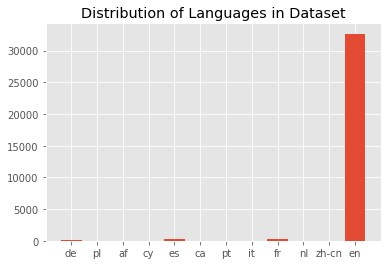

In [20]:
df['language'] = languages
plt.bar(range(len(languages_dict)), list(languages_dict.values()), align='center')
plt.xticks(range(len(languages_dict)), list(languages_dict.keys()))
plt.title("Distribution of Languages in Dataset")
plt.show()

In [21]:
df = df[df['language'] == 'en'] 
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32651 entries, 1625 to 36008
Data columns (total 12 columns):
paper_id               32651 non-null object
doi                    32651 non-null object
abstract               32651 non-null object
body_text              32651 non-null object
authors                32651 non-null object
title                  32651 non-null object
journal                32651 non-null object
abstract_summary       32651 non-null object
abstract_word_count    32651 non-null int64
body_word_count        32651 non-null int64
body_unique_words      32651 non-null int64
language               32651 non-null object
dtypes: int64(3), object(9)
memory usage: 3.2+ MB


In [22]:
from IPython.utils import io

with io.capture_output() as captured:
    !pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_core_sci_lg-0.2.4.tar.gz   

In [23]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_sci_lg

In [24]:
import string

punctuations = string.punctuation
stopwords = list(STOP_WORDS)
stopwords[:10]

['move',
 'whereas',
 'her',
 'thereafter',
 'too',
 'get',
 'so',
 'why',
 'my',
 'since']

In [25]:
custom_stop_words = [
    'doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure', 
    'rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 
    'al.', 'Elsevier', 'PMC', 'CZI', 'www'
]

for w in custom_stop_words:
    if w not in stopwords:
        stopwords.append(w)

In [26]:
parser = en_core_sci_lg.load(disable=["tagger", "ner"])
parser.max_length = 7000000

def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in stopwords and word not in punctuations ]
    mytokens = " ".join([i for i in mytokens])
    return mytokens

In [27]:
tqdm.pandas()
df["processed_text"] = df["body_text"].progress_apply(spacy_tokenizer)

C:\Users\Nick PC\Anaconda3\lib\site-packages\tqdm\std.py:648: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████████████████████████████████████████████████████████████████████| 32651/32651 [3:08:38<00:00,  2.88it/s]


In [28]:
import seaborn as sns

count     32651.000000
mean       4603.196166
std        5054.894876
min           6.000000
25%        2488.500000
50%        3733.000000
75%        5502.000000
max      232431.000000
Name: body_word_count, dtype: float64

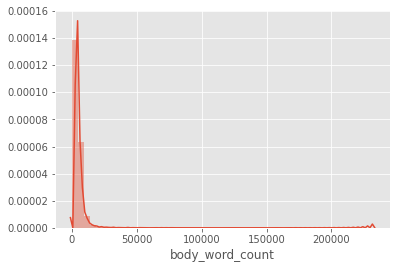

In [29]:
sns.distplot(df['body_word_count'])
df['body_word_count'].describe()

count    32651.000000
mean      1418.462130
std        931.570646
min          6.000000
25%        933.000000
50%       1260.000000
75%       1691.000000
max      30523.000000
Name: body_unique_words, dtype: float64

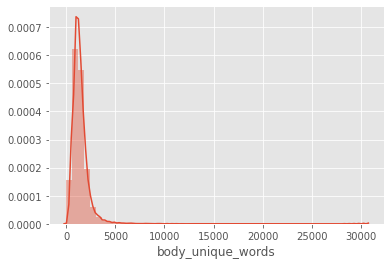

In [30]:
sns.distplot(df['body_unique_words'])
df['body_unique_words'].describe()

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
def vectorize(text, maxx_features):
    
    vectorizer = TfidfVectorizer(max_features=maxx_features)
    X = vectorizer.fit_transform(text)
    return X

In [32]:
text = df['processed_text'].values
X = vectorize(text, 2 ** 12)
X.shape

In [33]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95, random_state=42)
X_reduced= pca.fit_transform(X.toarray())
X_reduced.shape

(32651, 2463)

In [34]:
from sklearn.cluster import KMeans

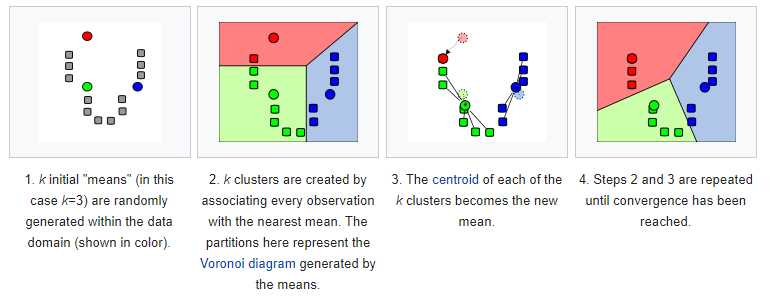

In [35]:
Image(filename='resources/kmeans.png', width=800, height=800)

In [36]:
from sklearn import metrics
from scipy.spatial.distance import cdist
distortions = []
K = range(2, 50)
for k in K:
    k_means = KMeans(n_clusters=k, random_state=42, n_jobs=-1).fit(X_reduced)
    k_means.fit(X_reduced)
    distortions.append(sum(np.min(cdist(X_reduced, k_means.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])


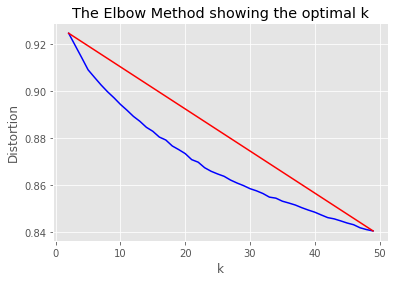

In [37]:
X_line = [K[0], K[-1]]
Y_line = [distortions[0], distortions[-1]]

plt.plot(K, distortions, 'b-')
plt.plot(X_line, Y_line, 'r')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [38]:
k = 20
kmeans = KMeans(n_clusters=k, random_state=42, n_jobs=-1)
y_pred = kmeans.fit_predict(X_reduced)
df['y'] = y_pred

In [39]:
from sklearn.manifold import TSNE

tsne = TSNE(verbose=1, perplexity=100, random_state=42)
X_embedded = tsne.fit_transform(X.toarray())

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 32651 samples in 21.234s...
[t-SNE] Computed neighbors for 32651 samples in 5669.369s...
[t-SNE] Computed conditional probabilities for sample 1000 / 32651
[t-SNE] Computed conditional probabilities for sample 2000 / 32651
[t-SNE] Computed conditional probabilities for sample 3000 / 32651
[t-SNE] Computed conditional probabilities for sample 4000 / 32651
[t-SNE] Computed conditional probabilities for sample 5000 / 32651
[t-SNE] Computed conditional probabilities for sample 6000 / 32651
[t-SNE] Computed conditional probabilities for sample 7000 / 32651
[t-SNE] Computed conditional probabilities for sample 8000 / 32651
[t-SNE] Computed conditional probabilities for sample 9000 / 32651
[t-SNE] Computed conditional probabilities for sample 10000 / 32651
[t-SNE] Computed conditional probabilities for sample 11000 / 32651
[t-SNE] Computed conditional probabilities for sample 12000 / 32651
[t-SNE] Computed conditional probabilities fo

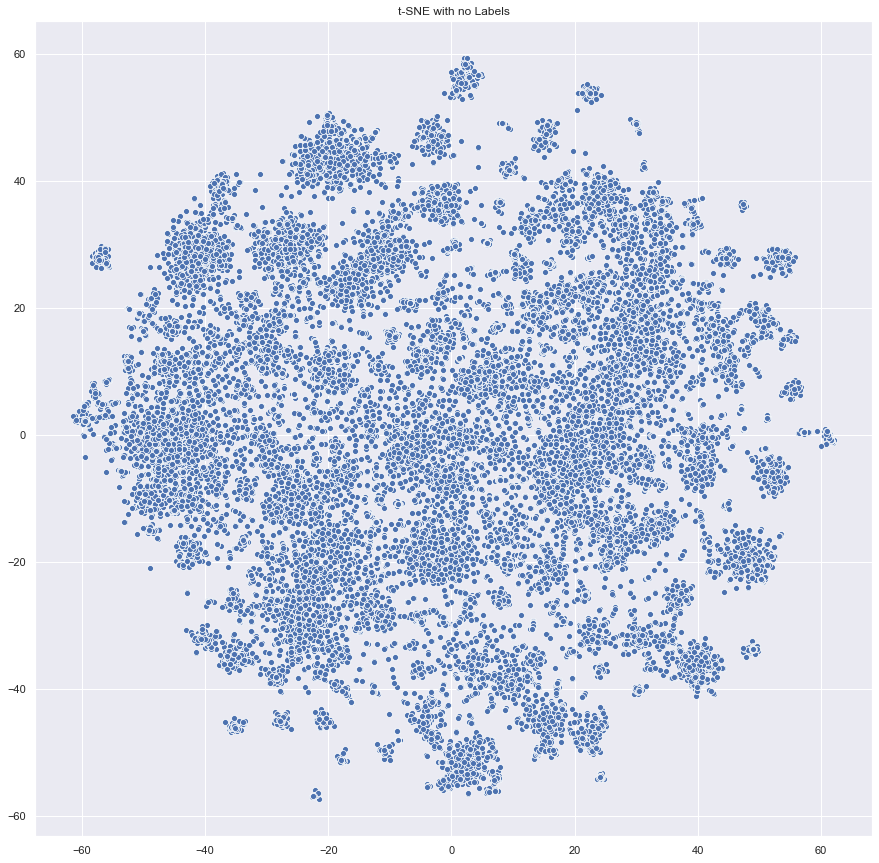

In [40]:
from matplotlib import pyplot as plt
import seaborn as sns

sns.set(rc={'figure.figsize':(15,15)})

palette = sns.color_palette("bright", 1)

sns.scatterplot(X_embedded[:,0], X_embedded[:,1], palette=palette)
plt.title('t-SNE with no Labels')
plt.savefig("plots/t-sne_covid19.png")
plt.show()

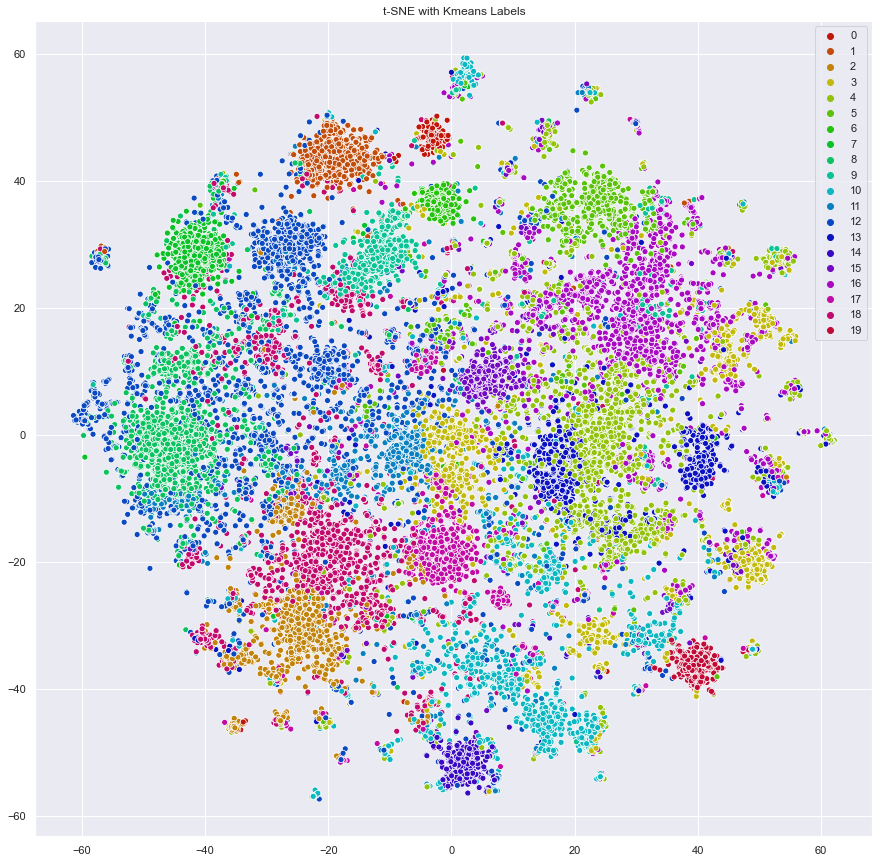

In [41]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

sns.set(rc={'figure.figsize':(15, 15)})

palette = sns.hls_palette(20, l=.4, s=.9)

sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y_pred, legend='full', palette=palette)
plt.title('t-SNE with Kmeans Labels')
plt.savefig("plots/improved_cluster_tsne.png")
plt.show()

In [42]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

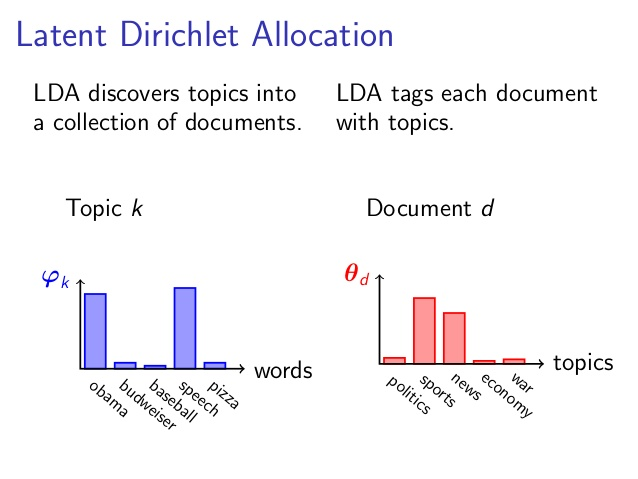

In [43]:
Image(filename='resources/lda.jpg', width=600, height=600)

In [44]:
vectorizers = []
    
for ii in range(0, 20):
    vectorizers.append(CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}'))

In [45]:
vectorizers[0]

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=0.9, max_features=None, min_df=5,
                ngram_range=(1, 1), preprocessor=None, stop_words='english',
                strip_accents=None, token_pattern='[a-zA-Z\\-][a-zA-Z\\-]{2,}',
                tokenizer=None, vocabulary=None)

In [46]:
vectorized_data = []

for current_cluster, cvec in enumerate(vectorizers):
    try:
        vectorized_data.append(cvec.fit_transform(df.loc[df['y'] == current_cluster, 'processed_text']))
    except Exception as e:
        print("Not enough instances in cluster: " + str(current_cluster))
        vectorized_data.append(None)

In [47]:
len(vectorized_data)

20

In [48]:
NUM_TOPICS_PER_CLUSTER = 20

lda_models = []
for ii in range(0, 20):
    lda = LatentDirichletAllocation(n_components=NUM_TOPICS_PER_CLUSTER, max_iter=10, learning_method='online',verbose=False, random_state=42)
    lda_models.append(lda)
    
lda_models[0]

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=20, n_jobs=None,
                          perp_tol=0.1, random_state=42, topic_word_prior=None,
                          total_samples=1000000.0, verbose=False)

In [49]:
clusters_lda_data = []

for current_cluster, lda in enumerate(lda_models):
    
    if vectorized_data[current_cluster] != None:
        clusters_lda_data.append((lda.fit_transform(vectorized_data[current_cluster])))

In [50]:
def selected_topics(model, vectorizer, top_n=3):
    current_words = []
    keywords = []
    
    for idx, topic in enumerate(model.components_):
        words = [(vectorizer.get_feature_names()[i], topic[i]) for i in topic.argsort()[:-top_n - 1:-1]]
        for word in words:
            if word[0] not in current_words:
                keywords.append(word)
                current_words.append(word[0])
                
    keywords.sort(key = lambda x: x[1])  
    keywords.reverse()
    return_values = []
    for ii in keywords:
        return_values.append(ii[0])
    return return_values

In [51]:
all_keywords = []
for current_vectorizer, lda in enumerate(lda_models):

    if vectorized_data[current_vectorizer] != None:
        all_keywords.append(selected_topics(lda, vectorizers[current_vectorizer]))

In [52]:
all_keywords[0][:10]

['protein',
 'illness',
 'hcov-',
 'nsp',
 'hcov-oc',
 'cns',
 'mouse',
 'disorder',
 'codon',
 'lipid']

In [53]:
len(all_keywords)

20

In [54]:
f=open('lib/topics.txt','w')

count = 0

for ii in all_keywords:

    if vectorized_data[count] != None:
        f.write(', '.join(ii) + "\n")
    else:
        f.write("Not enough instances to be determined. \n")
        f.write(', '.join(ii) + "\n")
    count += 1

f.close()

In [55]:
import pickle

pickle.dump(df, open("plot_data/df_covid.p", "wb" ))

pickle.dump(X_embedded, open("plot_data/X_embedded.p", "wb" ))

pickle.dump(y_pred, open("plot_data/y_pred.p", "wb" ))

In [56]:
def classification_report(model_name, test, pred):
    from sklearn.metrics import precision_score, recall_score
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import f1_score
    
    print(model_name, ":\n")
    print("Accuracy Score: ", '{:,.3f}'.format(float(accuracy_score(test, pred)) * 100), "%")
    print("     Precision: ", '{:,.3f}'.format(float(precision_score(test, pred, average='macro')) * 100), "%")
    print("        Recall: ", '{:,.3f}'.format(float(recall_score(test, pred, average='macro')) * 100), "%")
    print("      F1 score: ", '{:,.3f}'.format(float(f1_score(test, pred, average='macro')) * 100), "%")

In [57]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X.toarray(),y_pred, test_size=0.2, random_state=42)

print("X_train size:", len(X_train))
print("X_test size:", len(X_test), "\n")

X_train size: 26120
X_test size: 6531 



In [58]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import SGDClassifier
sgd_clf.fit(X_train, y_train)
sgd_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3, n_jobs=-1)
classification_report("Stochastic Gradient Descent Report (Training Set)", y_train, sgd_pred)

Stochastic Gradient Descent Report (Training Set) :

Accuracy Score:  91.466 %
     Precision:  93.043 %
        Recall:  91.744 %
      F1 score:  92.305 %


In [59]:
sgd_pred = cross_val_predict(sgd_clf, X_test, y_test, cv=3, n_jobs=-1)
classification_report("Stochastic Gradient Descent Report (Training Set)", y_test, sgd_pred)

Stochastic Gradient Descent Report (Training Set) :

Accuracy Score:  87.031 %
     Precision:  88.753 %
        Recall:  88.454 %
      F1 score:  88.532 %


In [60]:
sgd_cv_score = cross_val_score(sgd_clf, X.toarray(), y_pred, cv=10)
print("Mean cv Score - SGD: {:,.3f}".format(float(sgd_cv_score.mean()) * 100), "%")

Mean cv Score - SGD: 91.967 %


In [98]:
from lib.plot_text import header, description, description2, cite, description_search, description_slider, notes, dataset_description, toolbox_header 
from lib.call_backs import input_callback, selected_code
import bokeh
from bokeh.models import ColumnDataSource, HoverTool, LinearColorMapper, CustomJS, Slider, TapTool, TextInput
from bokeh.palettes import Category20
from bokeh.transform import linear_cmap, transform
from bokeh.io import output_file, show, output_notebook
from bokeh.plotting import figure
from bokeh.models import RadioButtonGroup, TextInput, Div, Paragraph
from bokeh.layouts import column, widgetbox, row, layout
from bokeh.layouts import column

In [99]:
import os

topic_path = os.path.join(os.getcwd(), 'lib', 'topics.txt')
with open(topic_path) as f:
    topics = f.readlines()

In [147]:
output_notebook()
y_labels = y_pred

source = ColumnDataSource(data=dict(
    x= X_embedded[:,0], 
    y= X_embedded[:,1],
    x_backup = X_embedded[:,0],
    y_backup = X_embedded[:,1],
    desc= y_labels, 
    titles= df['title'],
    authors = df['authors'],
    journal = df['journal'],
    abstract = df['abstract_summary'],
    labels = ["C-" + str(x) for x in y_labels],
    links = df['doi']
    ))

hover = HoverTool(tooltips=[
    ("Title", "@titles{safe}"),
    ("Author(s)", "@authors{safe}"),
    ("Journal", "@journal"),
    ("Abstract", "@abstract{safe}"),
    ("Link", "@links")
],
point_policy="follow_mouse")

initial_palette = Category20[20]
random.Random(42).shuffle(initial_palette)

mapper = linear_cmap(field_name='desc', 
                     palette=Category20[20],
                     low=min(y_labels) ,high=max(y_labels))

plot = figure(plot_width=1200, plot_height=850, 
           tools=[hover, 'pan', 'wheel_zoom', 'box_zoom', 'reset', 'save', 'tap'], 
           title="Clustering of the COVID-19 Literature with t-SNE and K-Means", 
           toolbar_location="above")

plot.scatter('x', 'y', size=5, 
          source=source,
          fill_color=mapper,
          line_alpha=0.3,
          line_width=1.1,
          line_color="black",
          legend = 'labels')
plot.legend.background_fill_alpha = 0.6

Loading BokehJS ...

In [148]:
text_banner = Paragraph(text= 'Keywords: Slide to specific cluster to see the keywords.', height=25)
input_callback_1 = input_callback(plot, source, text_banner, topics)

div_curr = Div(text="""Click on a plot to see the link to the article.""",height=150)
callback_selected = CustomJS(args=dict(source=source, current_selection=div_curr), code=selected_code())
taptool = plot.select(type=TapTool)
taptool.callback = callback_selected

slider = Slider(start=0, end=20, value=20, step=1, title="Cluster #", callback=input_callback_1)
keyword = TextInput(title="Search:", callback=input_callback_1)

input_callback_1.args["text"] = keyword
input_callback_1.args["slider"] = slider


In [149]:
header.sizing_mode = "stretch_width"
header.style={'color': '#2e484c', 'font-family': 'Julius Sans One, sans-serif;'}
header.margin=5

description.style ={'font-family': 'Helvetica Neue, Helvetica, Arial, sans-serif;', 'font-size': '1.1em'}
description.sizing_mode = "stretch_width"
description.margin = 5

description2.sizing_mode = "stretch_width"
description2.style ={'font-family': 'Helvetica Neue, Helvetica, Arial, sans-serif;', 'font-size': '1.1em'}
description2.margin=10

description_slider.style ={'font-family': 'Helvetica Neue, Helvetica, Arial, sans-serif;', 'font-size': '1.1em'}
description_slider.sizing_mode = "stretch_width"

description_search.style ={'font-family': 'Helvetica Neue, Helvetica, Arial, sans-serif;', 'font-size': '1.1em'}
description_search.sizing_mode = "stretch_width"
description_search.margin = 5

slider.sizing_mode = "stretch_width"
slider.margin=15

keyword.sizing_mode = "scale_both"
keyword.margin=15

div_curr.style={'color': '#BF0A30', 'font-family': 'Helvetica Neue, Helvetica, Arial, sans-serif;', 'font-size': '1.1em'}
div_curr.sizing_mode = "scale_both"
div_curr.margin = 20

text_banner.style={'color': '#0269A4', 'font-family': 'Helvetica Neue, Helvetica, Arial, sans-serif;', 'font-size': '1.1em'}
text_banner.sizing_mode = "scale_both"
text_banner.margin = 20

plot.sizing_mode = "scale_both"
plot.margin = 5

dataset_description.sizing_mode = "stretch_width"
dataset_description.style ={'font-family': 'Helvetica Neue, Helvetica, Arial, sans-serif;', 'font-size': '1.1em'}
dataset_description.margin=10

notes.sizing_mode = "stretch_width"
notes.style ={'font-family': 'Helvetica Neue, Helvetica, Arial, sans-serif;', 'font-size': '1.1em'}
notes.margin=10

cite.sizing_mode = "stretch_width"
cite.style ={'font-family': 'Helvetica Neue, Helvetica, Arial, sans-serif;', 'font-size': '1.1em'}
cite.margin=10

r = row(div_curr,text_banner)
r.sizing_mode = "stretch_width"

In [1]:
l = layout([
    [header],
    [description],
    [description_slider, description_search],
    [slider, keyword],
    [text_banner],
    [div_curr],
    [plot],
    [description2, dataset_description, notes, cite],
])
l.sizing_mode = "scale_both"
output_file('plots/t-sne_covid-19_interactive.html')
show(l)

NameError: name 'layout' is not defined

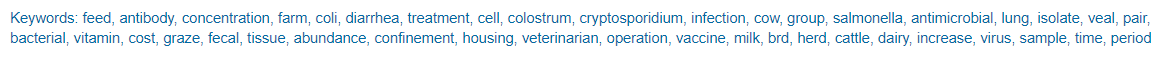

In [67]:
Image(filename="demo/cluster_9_keywords.png", width=1170, height=60)

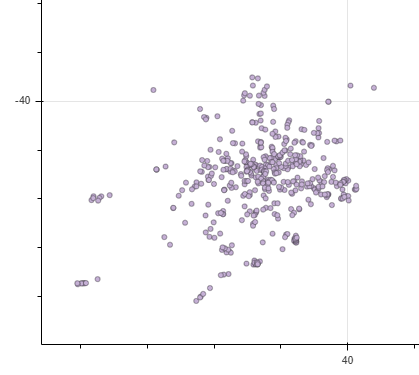

In [68]:
Image(filename='demo/cluster_9.png', width=420, height=375)

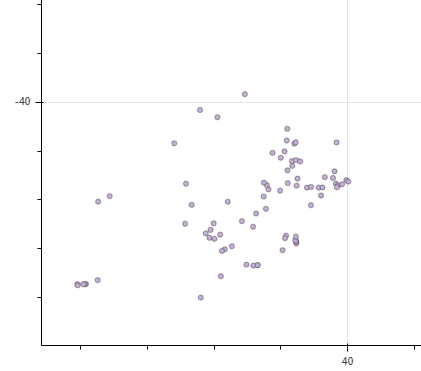

In [69]:
Image(filename='demo/cluster_9_cattle.png', width=420, height=375)

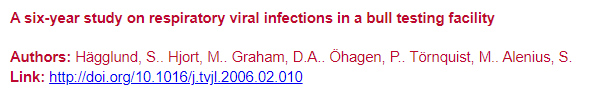

In [70]:
Image(filename='demo/selected_paper.png', width=600, height=100)